###### Image distinction between: buildings, forest, glacier, mountain, sea, street

In [130]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
import tempfile
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

print('Modules are imported.')

Modules are imported.


# Taking a look at some images from each category

In [131]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir,'data')

train_dir = os.path.join(data_dir,'train')
validation_dir = os.path.join(data_dir,'validation')

train_buildings_dir = os.path.join(train_dir,'buildings')
train_forest_dir = os.path.join(train_dir,'forest')
train_glacier_dir = os.path.join(train_dir,'glacier')
train_mountain_dir = os.path.join(train_dir,'mountain')
train_sea_dir = os.path.join(train_dir,'sea')
train_street_dir = os.path.join(train_dir,'street')

validation_buildings_dir = os.path.join(validation_dir,'buildings')
validation_forest_dir = os.path.join(validation_dir,'forest')
validation_glacier_dir = os.path.join(validation_dir,'glacier')
validation_mountain_dir = os.path.join(validation_dir,'mountain')
validation_sea_dir = os.path.join(validation_dir,'sea')
validation_street_dir = os.path.join(validation_dir,'street')

train_buildings_fnames = os.listdir(train_buildings_dir)
train_forest_fnames = os.listdir(train_forest_dir)
train_glacier_fnames = os.listdir(train_glacier_dir)
train_mountain_fnames = os.listdir(train_mountain_dir)
train_sea_fnames = os.listdir(train_sea_dir)
train_street_fnames = os.listdir(train_street_dir)

print('total training buildings images', len(train_buildings_fnames))
print('total training forest images', len(train_forest_fnames))
print('total training glacier images', len(train_glacier_fnames))
print('total training mountian images', len(train_mountain_fnames))
print('total training sea images', len(train_sea_fnames))
print('total training street images', len(train_street_fnames))

total training buildings images 2191
total training forest images 2271
total training glacier images 2404
total training mountian images 2512
total training sea images 2274
total training street images 2382


In [132]:
nrows=6
ncols=6
pic_index=0 #index for iterating over images

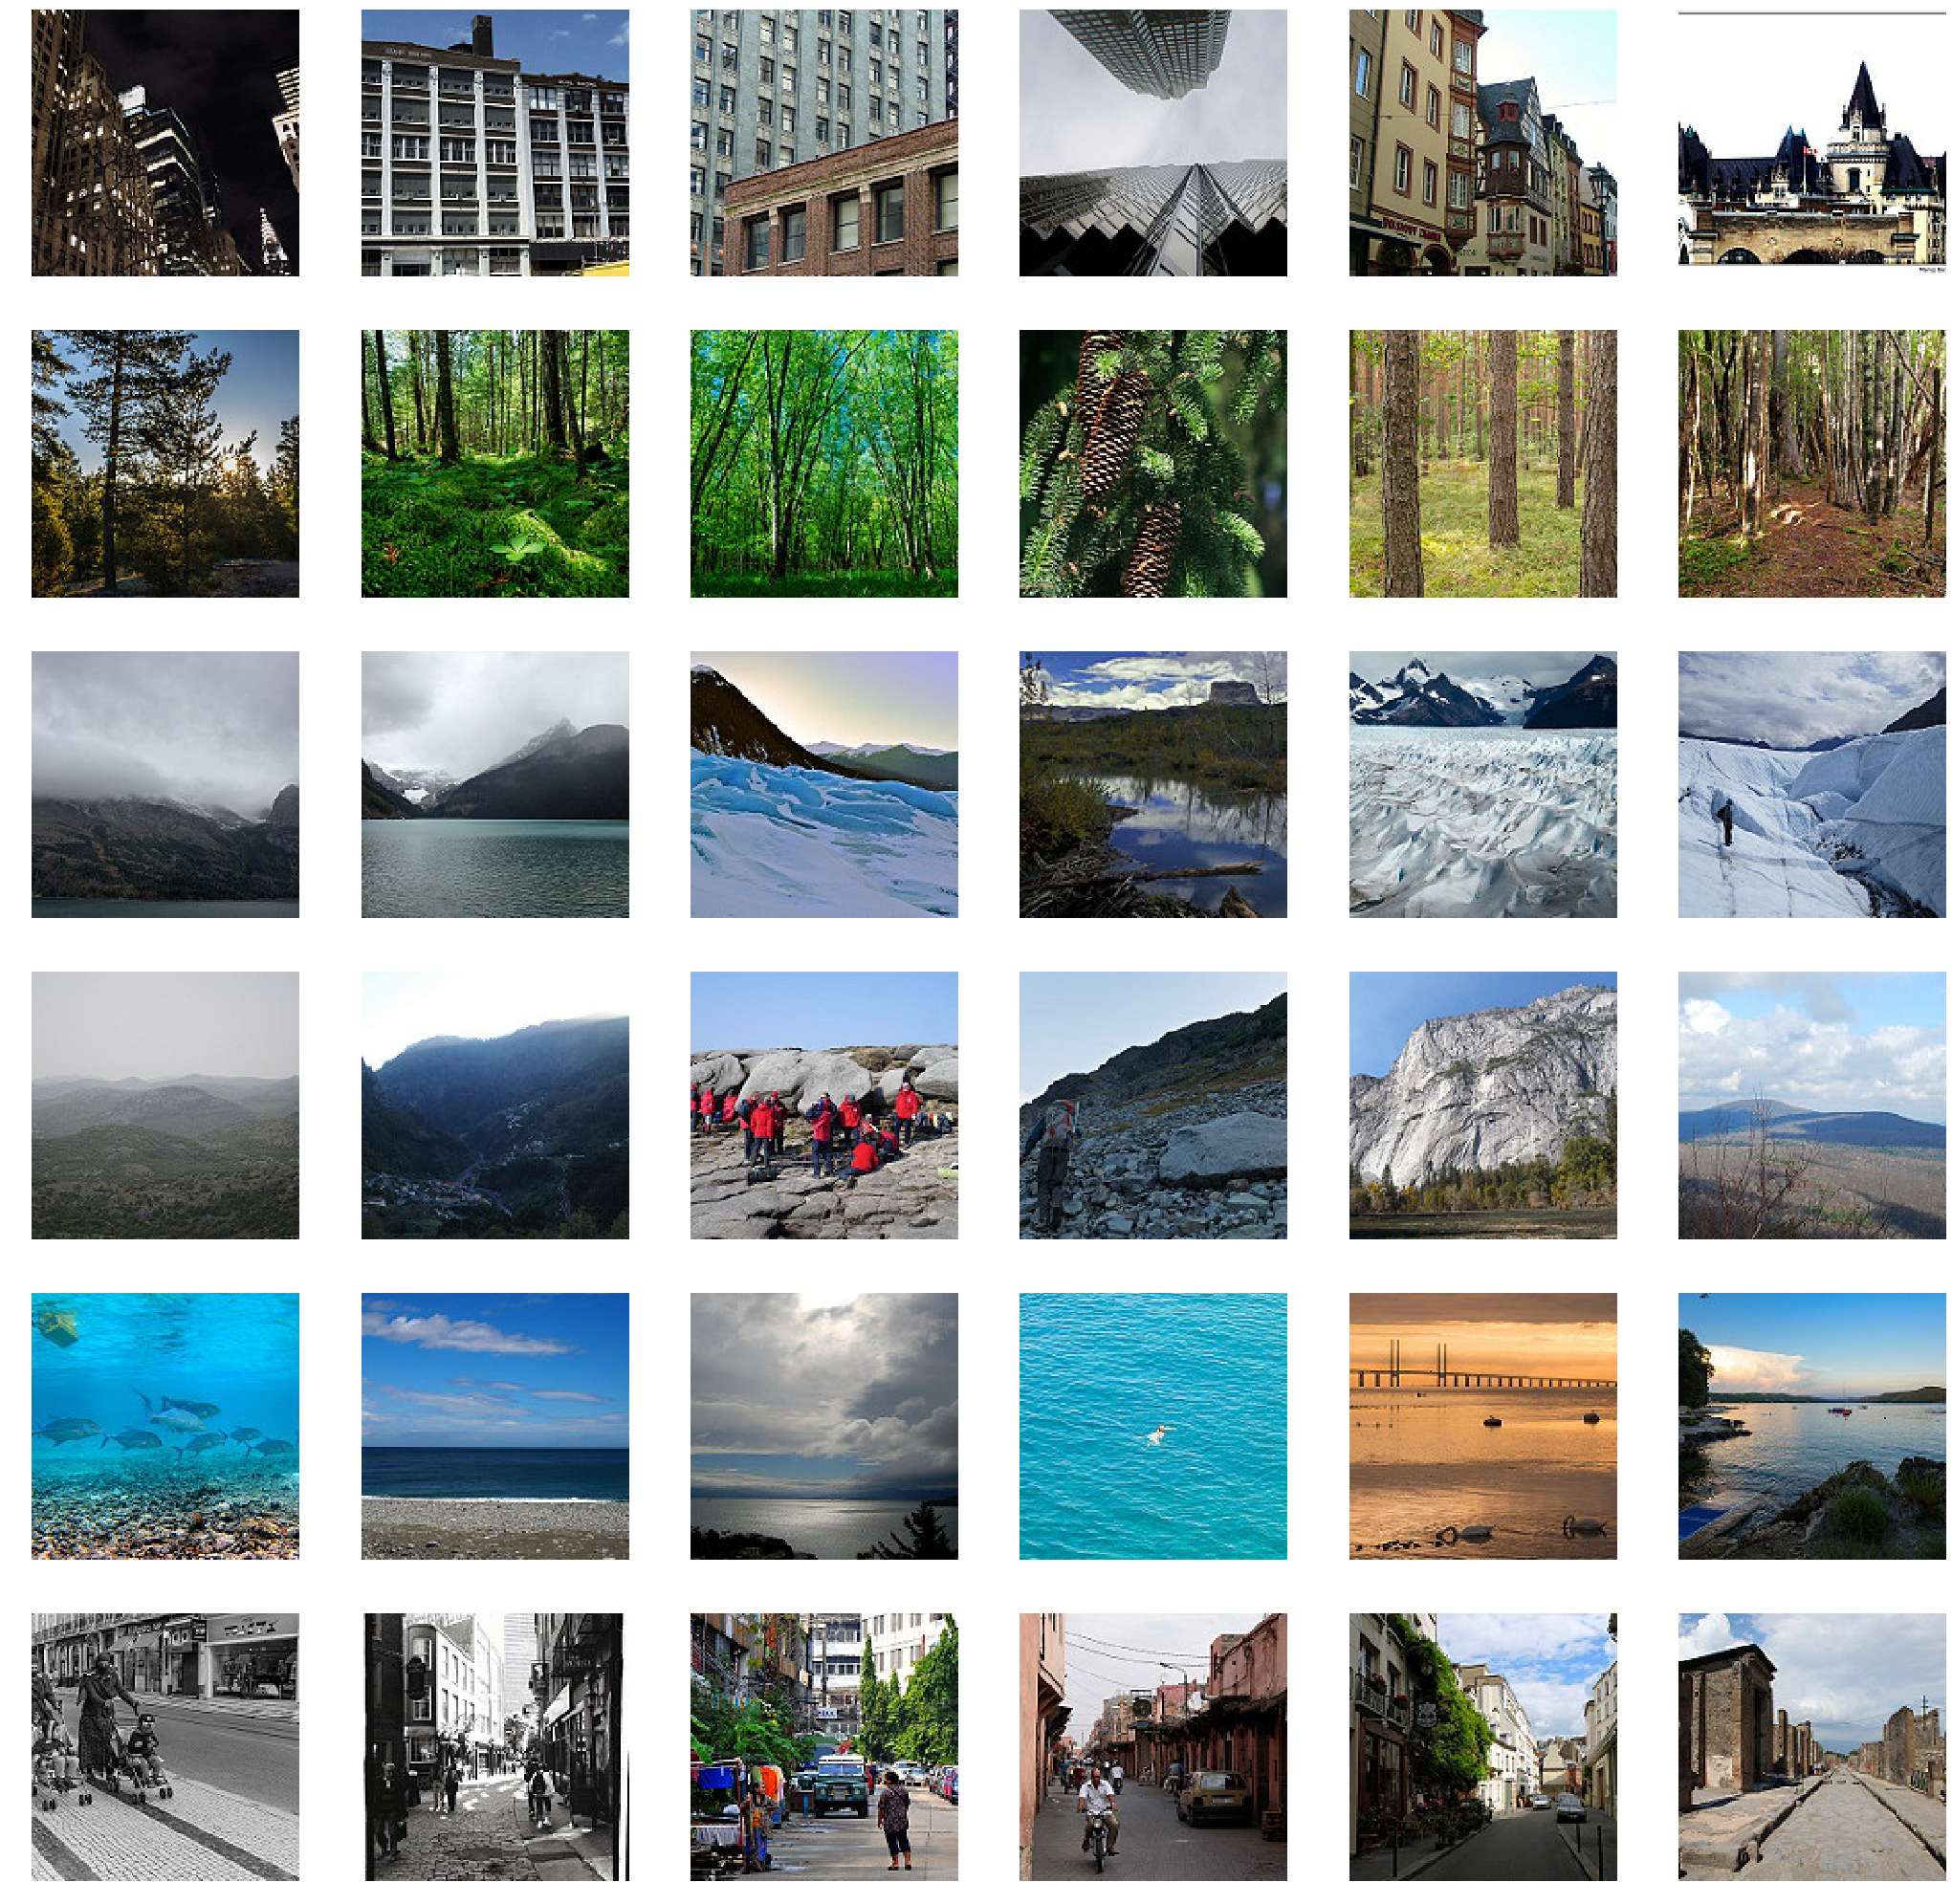

In [133]:
fig = plt.gcf()
fig.set_size_inches(ncols*6, nrows*6)

pic_index += 6

next_building_pix = [os.path.join(train_buildings_dir, fname)
                    for fname in train_buildings_fnames[pic_index-6:pic_index]]
next_forest_pix = [os.path.join(train_forest_dir, fname)
                    for fname in train_forest_fnames[pic_index-6:pic_index]]
next_glacier_pix = [os.path.join(train_glacier_dir, fname)
                    for fname in train_glacier_fnames[pic_index-6:pic_index]]
next_mountain_pix = [os.path.join(train_mountain_dir, fname)
                    for fname in train_mountain_fnames[pic_index-6:pic_index]]
next_sea_pix = [os.path.join(train_sea_dir, fname)
                    for fname in train_sea_fnames[pic_index-6:pic_index]]
next_street_pix = [os.path.join(train_street_dir, fname)
                    for fname in train_street_fnames[pic_index-6:pic_index]]

next_pix = next_building_pix + next_forest_pix + next_glacier_pix + next_mountain_pix + next_sea_pix + next_street_pix

for i, img_path in enumerate(next_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

# Making stacked convolution and pooling NN

In [134]:
#images are 150x150 pixels and 3 for the RGB color channels
img_input = layers.Input(shape=(150,150,3))

#First Conv extracts 16 filters, 3x3 ea followed by max-pooling layer
x = layers.Conv2D(16,3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

#Second Conv extracts 32 filters, 3x3 ea followed by max-pooling layer
x = layers.Conv2D(32,3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#Third Conv extrats 64 filters, 3x3 ea followed by max-pooling layer
x = layers.Conv2D(64,3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#Flatten feature map to 1-dim to add fully connected layer
x = layers.Flatten()(x)

#Fully connected layer with 512 hidden units
x = layers.Dense(50, activation='relu')(x)

#Dropout layer
x = layers.Dropout(0.5)(x)

#Create output layer with 6 nodes and softmax activation for prediction
output = layers.Dense(6, activation='softmax')(x)

#creating model:
#  input = input feature map
#  output = input feature map + stacked conv/max-pooling layers + softmax output
model = Model(img_input, output)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 64)        0         
__________

In [135]:
model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=.001),
             metrics=[metrics.categorical_accuracy])

In [136]:
#Building generators to yield batches of 20 images of size 150x150 pixels and labels
#  also normalizing pixel values from [0,255] to [0,1]

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir, #Source directory
    target_size=(150,150), #resizing all images to 150x150 pixels
    batch_size=20,
    class_mode='categorical',
    shuffle=True #choosing random training images
)

#flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,#Source directory
    target_size=(150,150), #resizing all images to 150x150 pixels
    batch_size=20,
    class_mode='categorical',
    shuffle=True #choosing random test images
)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [137]:
#training on 14000 images and testing on 3000
start = time.time()
model_history = model.fit_generator(
    train_generator,
    steps_per_epoch=700, #14000 images = 20 batch_size * 700 steps
    epochs=10,
    validation_data=validation_generator,
    validation_steps=150, #3000 images = 20 batch_size * 150 steps
    verbose=2
)
end = time.time()

print("Training time (mins) = ", (end - start)/60)

Epoch 1/10
150/150 [==============================] - 20s 136ms/step - loss: 0.7526 - categorical_accuracy: 0.7263
 - 304s - loss: 1.1675 - categorical_accuracy: 0.5520 - val_loss: 0.7526 - val_categorical_accuracy: 0.7263
Epoch 2/10
150/150 [==============================] - 19s 126ms/step - loss: 0.6908 - categorical_accuracy: 0.7573
 - 302s - loss: 0.8547 - categorical_accuracy: 0.6975 - val_loss: 0.6908 - val_categorical_accuracy: 0.7573
Epoch 3/10
150/150 [==============================] - 20s 133ms/step - loss: 0.6454 - categorical_accuracy: 0.7610
 - 300s - loss: 0.7521 - categorical_accuracy: 0.7438 - val_loss: 0.6454 - val_categorical_accuracy: 0.7610
Epoch 4/10
150/150 [==============================] - 20s 133ms/step - loss: 0.5813 - categorical_accuracy: 0.8187
 - 284s - loss: 0.7105 - categorical_accuracy: 0.7617 - val_loss: 0.5813 - val_categorical_accuracy: 0.8187
Epoch 5/10
150/150 [==============================] - 22s 148ms/step - loss: 0.6114 - categorical_accuracy: 

In [138]:
def plot_model_history(model_history, model):
    acc = model_history.history['categorical_accuracy']
    val_acc = model_history.history['val_categorical_accuracy']
    
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    
    num_epochs = range(len(acc))
    
    plt.plot(num_epochs,acc)
    plt.plot(num_epochs, val_acc)
    plt.title('Training and Validation accuracy')
    plt.legend(['Train','Test'], loc='upper left')
    
    plt.figure()
    plt.plot(num_epochs,loss)
    plt.plot(num_epochs,val_loss)
    plt.title('Training and Validation loss')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()
    
    
    #Making confusion matrix
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    prediction_generator = test_datagen.flow_from_directory(
    validation_dir,#Source directory
    target_size=(150,150), #resizing all images to 150x150 pixels
    batch_size=20,
    class_mode='categorical',
    shuffle=False
    )
    
    probabilities = model.predict_generator(prediction_generator)
    y_pred = np.argmax(probabilities, axis=1)
    true_labels = prediction_generator.classes
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_labels, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis = 1)[:,np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ticks_labels = ['buildings','forest','glacier','mountain','sea','street']
    ax.set(xticklabels=ticks_labels)
    ax.set(yticklabels=ticks_labels)
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
#     print("Confusion Matrix")
#     print(confusion_matrix(prediction_generator.classes,y_pred))
    

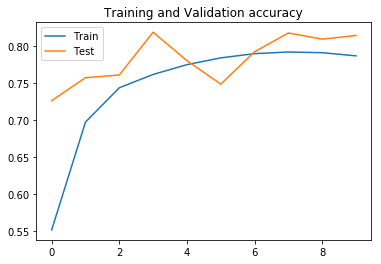

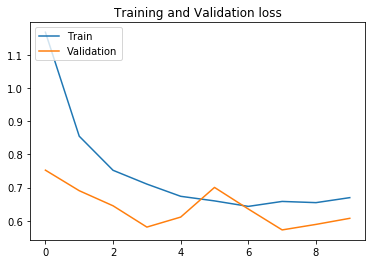

Found 3000 images belonging to 6 classes.


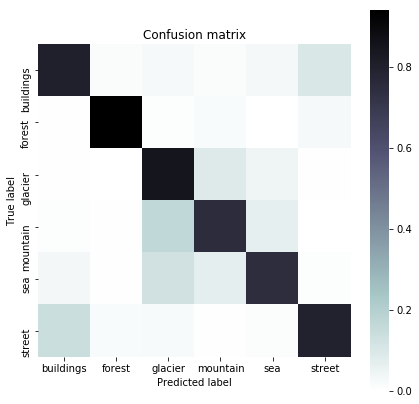

In [139]:
plot_model_history(model_history,model)


### We have achieved greater than 80% accuracy on the image classification!
#### Model is confusing mountains / glaciers / sea and buildings / streets.   That is how I would confuse the pictures too!

#### Looking at some individual predicitons

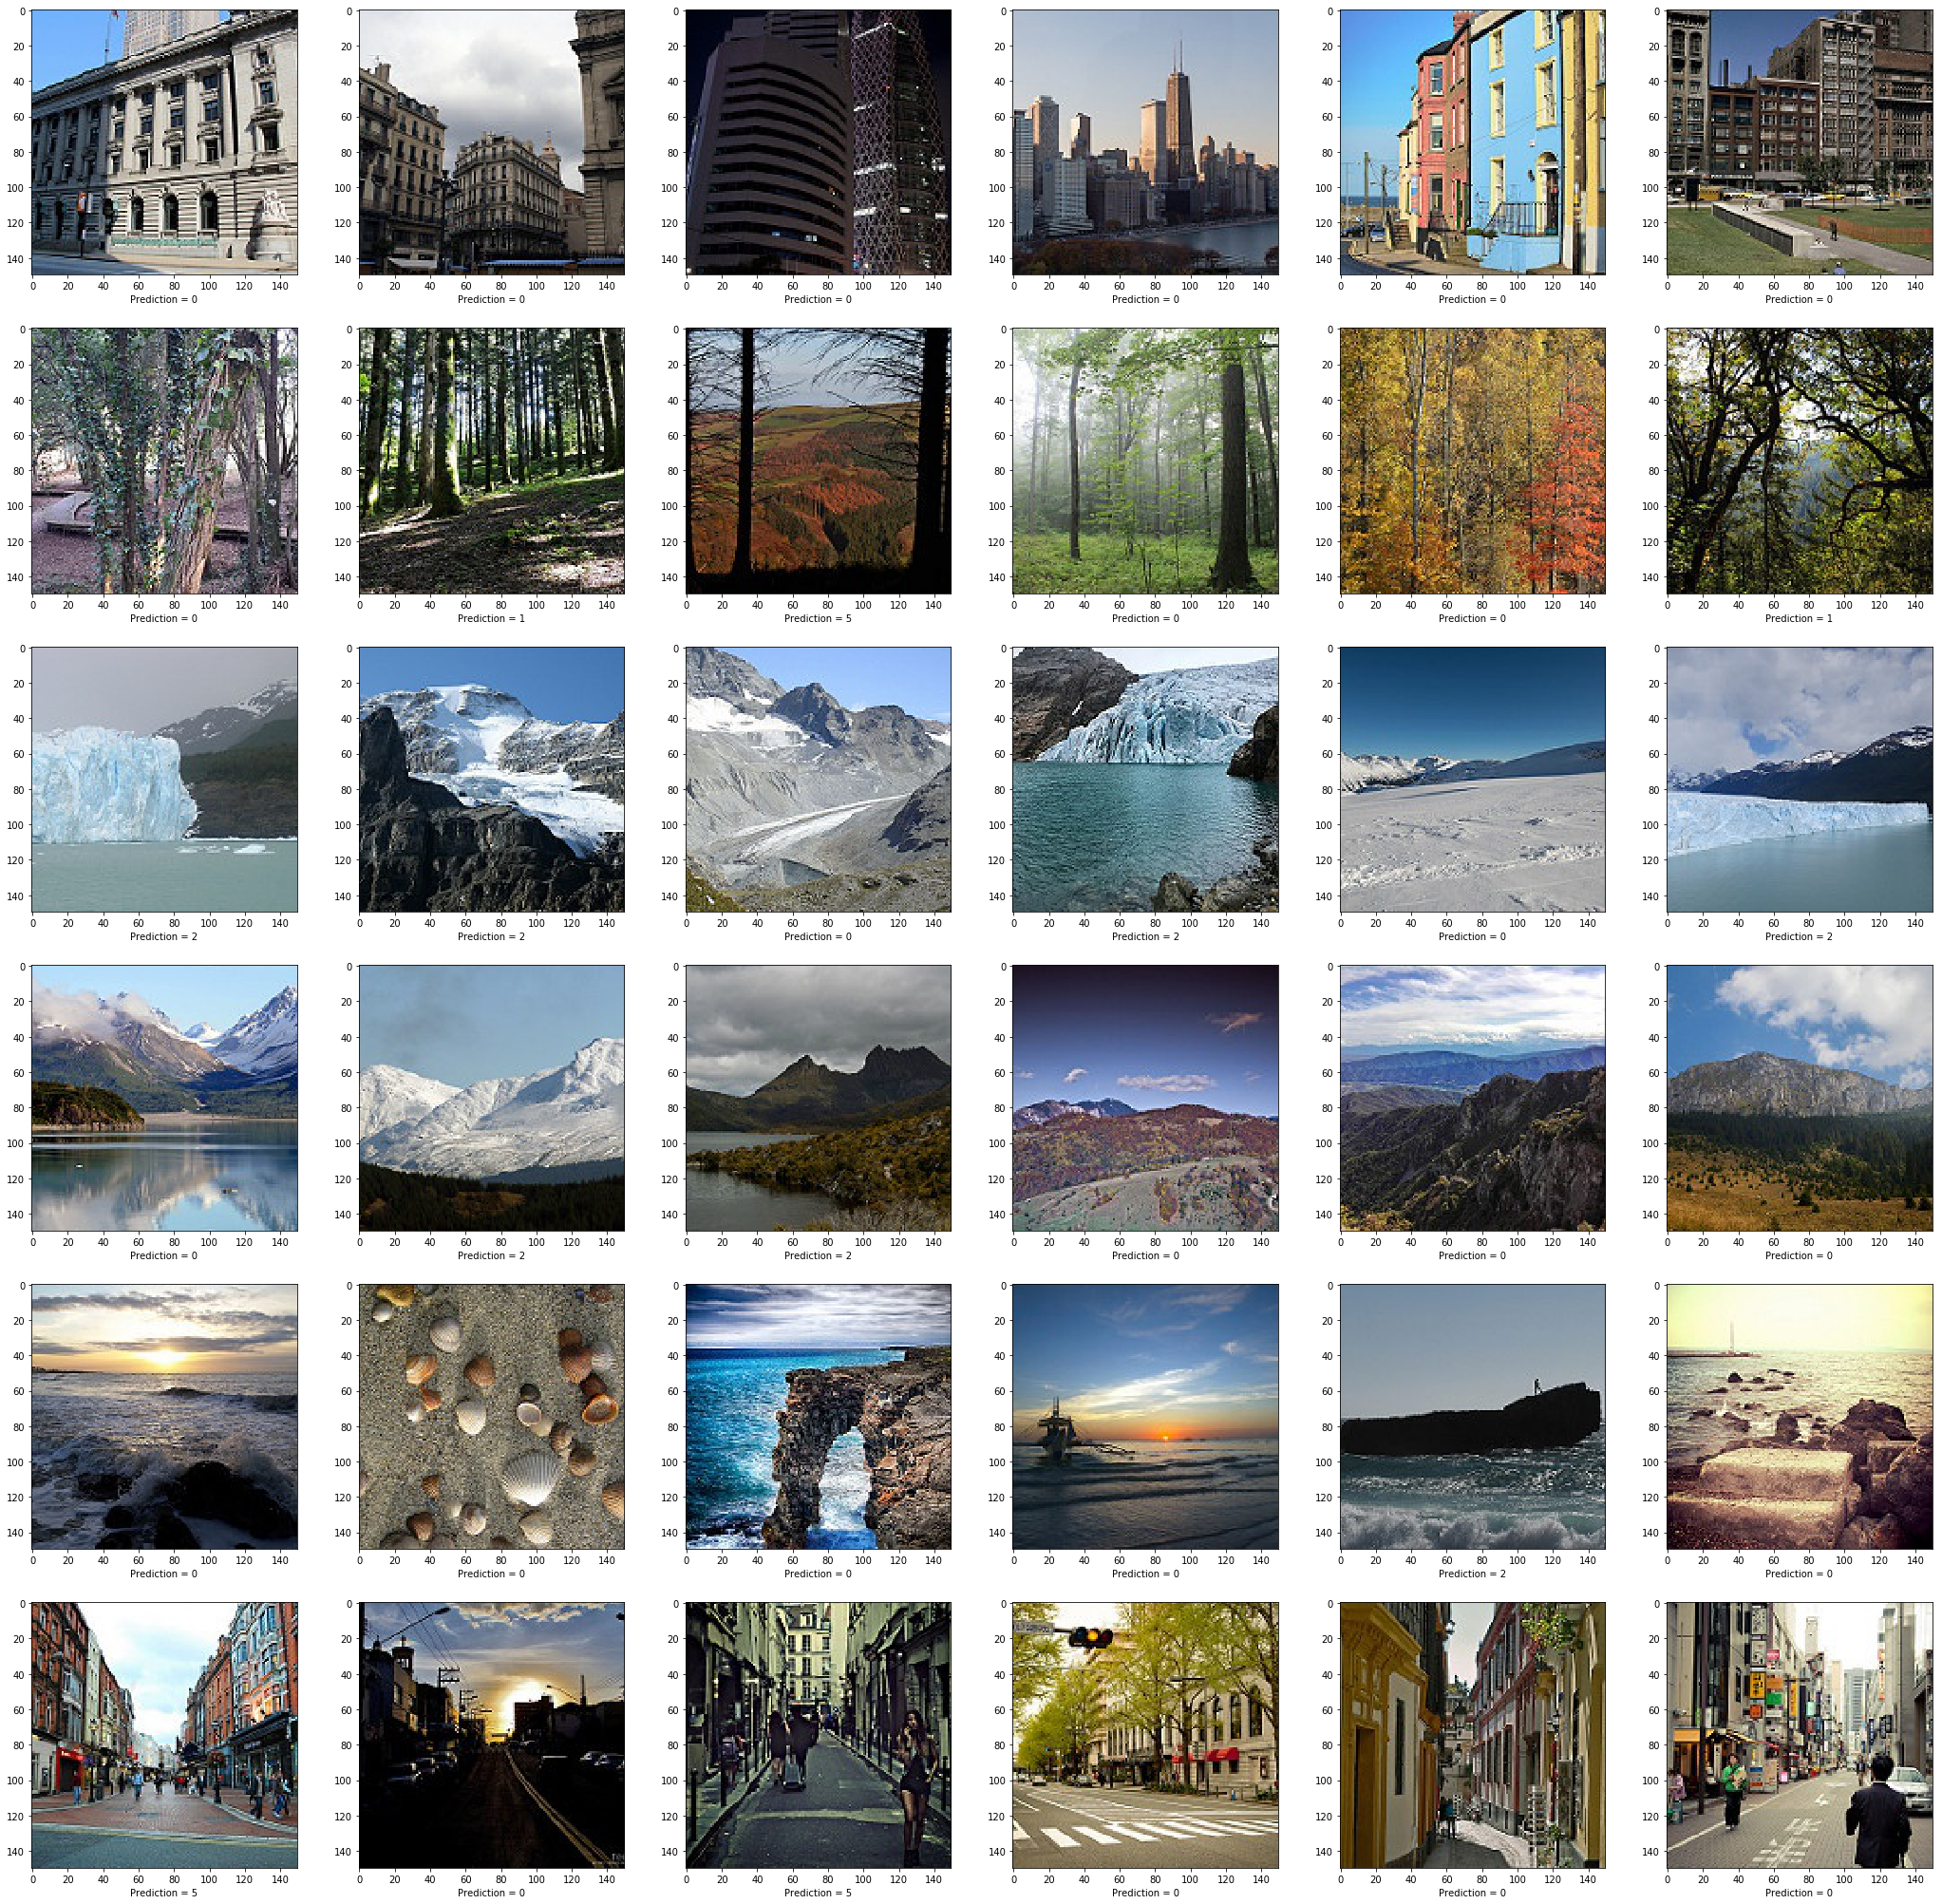

In [141]:
fig = plt.gcf()
fig.set_size_inches(ncols*6, nrows*6)

pic_index = np.random.randint(0,2000)

next_building_pix = [os.path.join(train_buildings_dir, fname)
                    for fname in train_buildings_fnames[pic_index-6:pic_index]]
next_forest_pix = [os.path.join(train_forest_dir, fname)
                    for fname in train_forest_fnames[pic_index-6:pic_index]]
next_glacier_pix = [os.path.join(train_glacier_dir, fname)
                    for fname in train_glacier_fnames[pic_index-6:pic_index]]
next_mountain_pix = [os.path.join(train_mountain_dir, fname)
                    for fname in train_mountain_fnames[pic_index-6:pic_index]]
next_sea_pix = [os.path.join(train_sea_dir, fname)
                    for fname in train_sea_fnames[pic_index-6:pic_index]]
next_street_pix = [os.path.join(train_street_dir, fname)
                    for fname in train_street_fnames[pic_index-6:pic_index]]

next_pix = next_building_pix + next_forest_pix + next_glacier_pix + next_mountain_pix + next_sea_pix + next_street_pix

for i, img_path in enumerate(next_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    img = load_img(img_path, target_size=(150,150))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    probabilities = model.predict(x)
    pred_label = "Prediction = " + str(np.argmax(probabilities))
    plt.xlabel(pred_label)
    
plt.show()
